In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
import os

current_dir = os.getcwd() 
parent_dir = os.path.join(current_dir, '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.plane_equation import PlaneEquation
from in2D.classifying.classes.utilss.convexity_check import (
    find_svm_meeting_point, 
    get_shared_vertices,
    find_epsilon_points,
    find_average_point,
    check_convexity,

)

In [2]:
def make_meshgrid(x, y, h=.01):
    x_min, x_max = x.min() , x.max()
    y_min, y_max = y.min() , y.max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [3]:
N=1000
C=1000
gamma=0.01
D=2 #dimension
t=8 #polytope order

X = np.random.normal(0,1,(N,D))
ws= np.random.normal(0,1,(t,D))
ws = ws / (np.linalg.norm(ws,axis=1).reshape(-1,1))

u=np.random.uniform(0,1,(N,1))
X=X/(np.linalg.norm(X,axis=1).reshape(-1,1))*(u**(1/D))

y=np.ones(N)

for index in range(N):
    z = 1
    for w in ws :
        if((X[index].dot(w)- 0.5 - gamma) > 0):
            z = -1
        else :
            if ((X[index].dot(w) - 0.4 -gamma) > 0):
                z =0
    y[index]=z

X=(X[y!= 0]+ [1,1])/2
y=y[y!= 0]

print("Dataset created:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")


Dataset created:
X shape: (786, 2)
y shape: (786,)
Classes: [-1.  1.]


## Find the meeting points


In [4]:
# Compute root simplex from data bounds (with small margin)
margin = 0.05
data_x_min, data_x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
data_y_min, data_y_max = X[:, 1].min() - margin, X[:, 1].max() + margin

# Create a right triangle that covers the data bounding box
root_vertices = [
    (data_x_min, data_y_min),                          # bottom-left
    (data_x_max + (data_x_max - data_x_min), data_y_min),  # extend right
    (data_x_min, data_y_max + (data_y_max - data_y_min))   # extend up
]
print(f"Root simplex vertices: {root_vertices}")


Root simplex vertices: [(-0.04734508300388597, -0.034188417739129354), (2.144219253195128, -0.034188417739129354), (-0.04734508300388597, 2.1265487821962354)]


In [5]:
subdivision_levels = 3
model = SimplexTreeClassifier(
    vertices=root_vertices,
    regularization=C,
    subdivision_levels=subdivision_levels,
    classifier_type='linear_svc'
)
model.fit(X, y)

weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

margin = 0.05
data_x_min, data_x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
data_y_min, data_y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
x_min, x_max = data_x_min - 0.05, data_x_max + 0.05
y_min, y_max = data_y_min - 0.05, data_y_max + 0.05
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

(786, 16)


Found 18 crossing simplices
Pairs - Convex: 10, Non-convex: 8
Non-convex simplices to highlight: 13


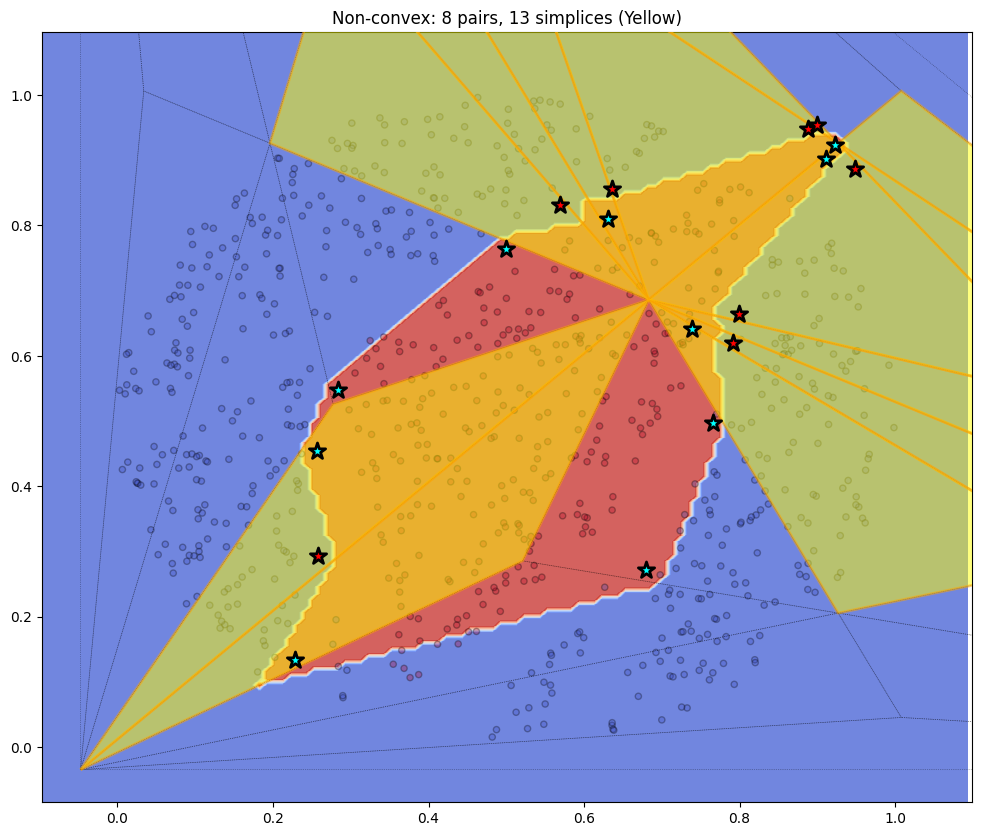

In [6]:
crossing_simplices = model.identify_svm_crossing_simplices()
print(f"Found {len(crossing_simplices)} crossing simplices")

EPSILON = 0.10

# Collect all data
all_data = []
nonconvex_simplex_keys = set()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            # check_convexity returns: is_convex, average, meeting, pt1, pt2
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept, 
                global_tree=model.tree, epsilon=EPSILON
            )
            
            if avg is not None:
                all_data.append({
                    'average': avg,
                    'meeting': meeting,
                    'pt1': pt1,
                    'pt2': pt2,
                    'is_convex': is_convex,
                    'simplex1': simplex1,
                    'simplex2': simplex2
                })
                
                if not is_convex:
                    nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                    nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

convex_count = sum(1 for d in all_data if d['is_convex'])
nonconvex_count = len(all_data) - convex_count
print(f"Pairs - Convex: {convex_count}, Non-convex: {nonconvex_count}")
print(f"Non-convex simplices to highlight: {len(nonconvex_simplex_keys)}")

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)

for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle=':', linewidth=0.5, alpha=0.5)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.3)

for leaf in model.leaf_simplexes:
    simplex_key = frozenset(leaf.vertex_indices)
    if simplex_key in nonconvex_simplex_keys:
        vertices = np.array(leaf.vertices)
        poly = patches.Polygon(vertices, closed=True, 
                             facecolor='yellow', alpha=0.5, 
                             edgecolor='orange', linewidth=2, zorder=6)
        ax.add_patch(poly)

for d in all_data:
    color = 'cyan' if d['is_convex'] else 'red'
    ax.scatter(d['average'][0], d['average'][1], c=color, s=150, zorder=11, marker='*', edgecolors='black', linewidth=2)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"Non-convex: {nonconvex_count} pairs, {len(nonconvex_simplex_keys)} simplices (Yellow)")
plt.show()

## Remove one non-convex simplex from the tree


Simplices to remove: 13
Leaves before removal: 27
(786, 16)
Removed 13 simplices
Leaves after removal: 16


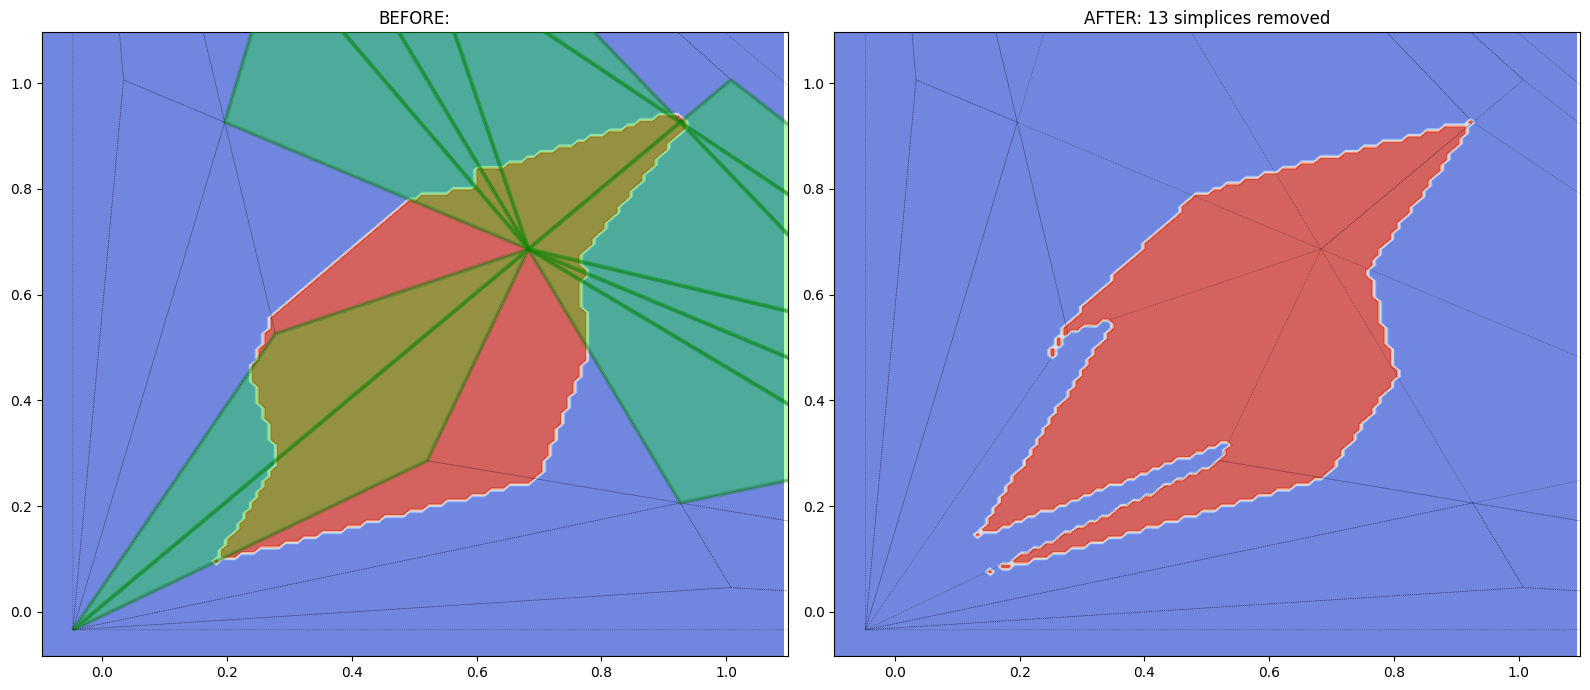

In [7]:
print(f"Simplices to remove: {len(nonconvex_simplex_keys)}")
print(f"Leaves before removal: {len(model.tree.get_leaves())}")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax = axes[0]
xy_before = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_before, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle=':', linewidth=0.5, alpha=0.5)
for leaf in model.tree.get_leaves():
    if frozenset(leaf.vertex_indices) in nonconvex_simplex_keys:
        vertices = np.array(leaf.vertices)
        poly = patches.Polygon(vertices, closed=True, 
                             facecolor='lime', alpha=0.3, 
                             edgecolor='green', linewidth=3, zorder=6)
        ax.add_patch(poly)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"BEFORE:")

removed_count = 0
for simplex_key in nonconvex_simplex_keys:
    if model.tree.remove_simplex_by_key(simplex_key):
        removed_count += 1

model._build_node_lookup()
model.fit(X, y)

print(f"Removed {removed_count} simplices")
print(f"Leaves after removal: {len(model.tree.get_leaves())}")

ax = axes[1]
xy_after = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_after, cmap=plt.cm.coolwarm, alpha=0.8)
for leaf in model.tree.get_leaves():
    vertices = leaf.get_vertices_as_tuples()
    if len(vertices) >= 3:
        closed = vertices + [vertices[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"AFTER: {removed_count} simplices removed")

plt.tight_layout()
plt.show()